In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

# Baseline GRU-based model trained on NDVI time series

In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

In [3]:
# Number of time stamps
N_ts = 11
# Number of bands
N_b = 10

VALID_AGG_METHODS = ['mean','median','min','max','std']

def load_for_id(farm_id, dataset, bands_subset=None):
    """
    Load all data for a farm
    
    Return:
    
    dictionary: {band: {date: ndarray}, {...}}
    """
    farm_dir = interim_data_dir / 'masks_v2' / dataset / str(farm_id)

    dates = farm_dir.glob('*/')
    farm_data = {}
    
    for date_path in dates:
        
        date = date_path.stem

        bands = date_path.glob("*.npy")
        
        farm_data[date_path.stem] = {}
        
        for band_path in bands:
            band = band_path.stem
            
            if bands_subset and band in bands_subset:
                arr = np.load(band_path)
                farm_data[date][band] = arr
        
    return farm_data

def calc_ndvi(bands_data):
    return (bands_data['B08'] - bands_data['B04'])/(bands_data['B08'] + bands_data['B04'])

def agg_arr(arr, agg_method):
    """
    aggregate an array with a nan-aware numpy method
    """
    assert agg_method in VALID_AGG_METHODS
    return eval(f'np.nan{agg_method}')(arr.flatten())

def calc_vi_ts(farm_data, farm_id, agg_methods, which_vi='ndvi'):
    """
    Calculate vegetation index time series for a farm
    """
    vi_data = {}
    for date, bands_data in farm_data.items():
        # Get aggregated statistics of VI signals for this date
        vi_data[date] = [agg_arr(eval(f'calc_{which_vi}')(bands_data), agg_method) for agg_method in agg_methods]
        
    vi = pd.DataFrame.from_dict(vi_data, orient='index')
    vi.index = pd.to_datetime(vi.index)
    vi.index.name='time'
    vi.columns = [f'{which_vi}_{agg_method}' for agg_method in agg_methods]
    
    return pd.concat([vi], keys=[farm_id], names=['farm_id'])

def create_features_dataset(dataset='train', bands_subset=['B08','B04'], agg_methods=['mean','median'], limit_farms=None):
    """
    
    """
    
    shp_df = read_shapefile(dataset)
    
    ids_list = shp_df.index.to_list()
    
    if limit_farms:
        ids_list = ids_list[:limit_farms]

    vi_dfs = []
    for farm_id in tqdm(ids_list, "farms"):
        
        farm_data = load_for_id(farm_id, dataset, bands_subset=bands_subset)
        
        vis = ['ndvi', 'ndwi']

        ndvi = calc_vi_ts(farm_data, farm_id, agg_methods, 'ndvi')

        # For now only one feature, but later we will concat multiple features
        vi_df = pd.concat([ndvi], axis=1)

        vi_dfs.append(vi_df)

    df = pd.concat(vi_dfs, axis=0).reset_index()
    
    if dataset=='train':
        df = df.join(shp_df[['y']], on='farm_id')
        
    df.time = pd.to_datetime(df.time)
    
    # Sort each farm by time
    df = df.sort_values(by=['farm_id','time'])
    
    # After sorting the index will be jumbled, lets throw that away
    df.reset_index(drop=True, inplace=True)
    
    return df
    
    

In [4]:
train_features_df = create_features_dataset(dataset='train', 
                                            bands_subset=['B08','B04'],
                                            agg_methods=['min','mean','median','std','max'])

farms: 100%|██████████| 2494/2494 [01:13<00:00, 33.87it/s]


In [5]:
train_features_df.head()

,farm_id,time,ndvi_min,ndvi_mean,ndvi_median,ndvi_std,ndvi_max,y
0,1,2017-01-01,0.454174,0.671766,0.692653,0.065668,0.745895,Vineyard
1,1,2017-01-31,0.586915,0.718396,0.729027,0.046242,0.781602,Vineyard
2,1,2017-02-10,0.633239,0.746055,0.755768,0.038175,0.798810,Vineyard
3,1,2017-03-12,0.514993,0.668629,0.684211,0.065733,0.765019,Vineyard
4,1,2017-03-22,0.511155,0.659258,0.673052,0.055294,0.747845,Vineyard


In [6]:
test_features_df = create_features_dataset(dataset='test', 
                                            bands_subset=['B08','B04'],
                                            agg_methods=['min','mean','median','std','max'])

farms: 100%|██████████| 1074/1074 [00:26<00:00, 40.70it/s]


In [7]:
test_features_df.head()

,farm_id,time,ndvi_min,ndvi_mean,ndvi_median,ndvi_std,ndvi_max
0,5,2017-01-01,0.349809,0.689752,0.731648,0.087024,0.772183
1,5,2017-01-31,0.472635,0.773126,0.808656,0.073912,0.837321
2,5,2017-02-10,0.497143,0.774520,0.797879,0.054864,0.826981
3,5,2017-03-12,0.428204,0.720137,0.754934,0.073023,0.786667
4,5,2017-03-22,0.445312,0.613666,0.632955,0.055730,0.684131


## Normalize Features Dataset

In [8]:
train_copy = train_features_df.copy()
test_copy = test_features_df.copy()

In [9]:
from sklearn.preprocessing import MinMaxScaler

times = train_features_df['time'].unique()
feature_cols = ['ndvi_min','ndvi_mean','ndvi_median','ndvi_std','ndvi_max']

for ts in times:
    scaler = MinMaxScaler()
    
    train_ts_df = train_copy[train_copy.time == ts]
    test_ts_df = test_copy[test_copy.time == ts]
    
    train_features_df.loc[train_ts_df.index, feature_cols] = scaler.fit_transform(train_ts_df[feature_cols])
    test_features_df.loc[test_ts_df.index, feature_cols] = scaler.transform(test_ts_df[feature_cols])

## Visualize effect of normalization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

agg_df_1 = train_copy.groupby(['time','y']).agg({
    'ndvi_median': np.median, 
    'ndvi_mean': np.median, 
    'ndvi_min': np.median, 
    'ndvi_max': np.median,
    'ndvi_std': np.median,
}).reset_index()

agg_df_2 = train_features_df.groupby(['time','y']).agg({
    'ndvi_median': np.median, 
    'ndvi_mean': np.median, 
    'ndvi_min': np.median, 
    'ndvi_max': np.median,
    'ndvi_std': np.median,
}).reset_index()

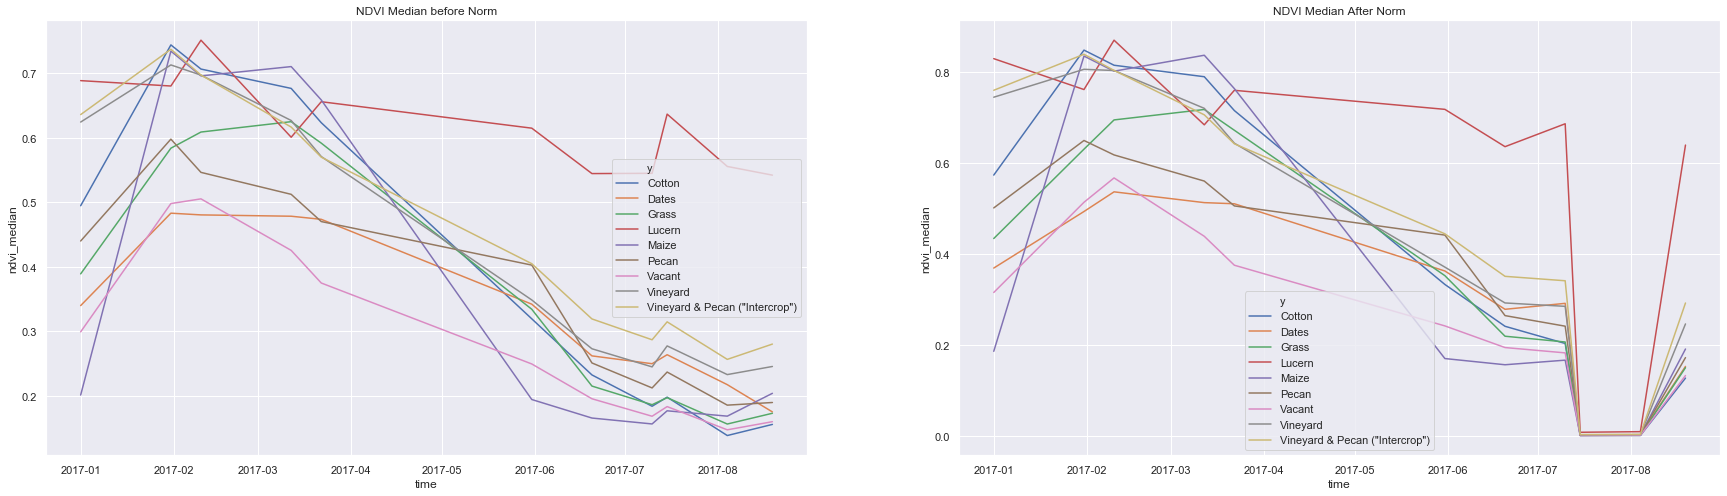

In [11]:
fig, axes = plt.subplots(1,2,figsize=(30,8))

ax = axes[0]
sns.lineplot(data=agg_df_1, x='time', y='ndvi_median', hue='y', ax=ax)
ax.set_title('NDVI Median before Norm')
ax.legend(loc='best')

ax = axes[1]
sns.lineplot(data=agg_df_2, x='time', y='ndvi_median', hue='y', ax=ax)
ax.set_title('NDVI Median After Norm')
ax.legend(loc='best')

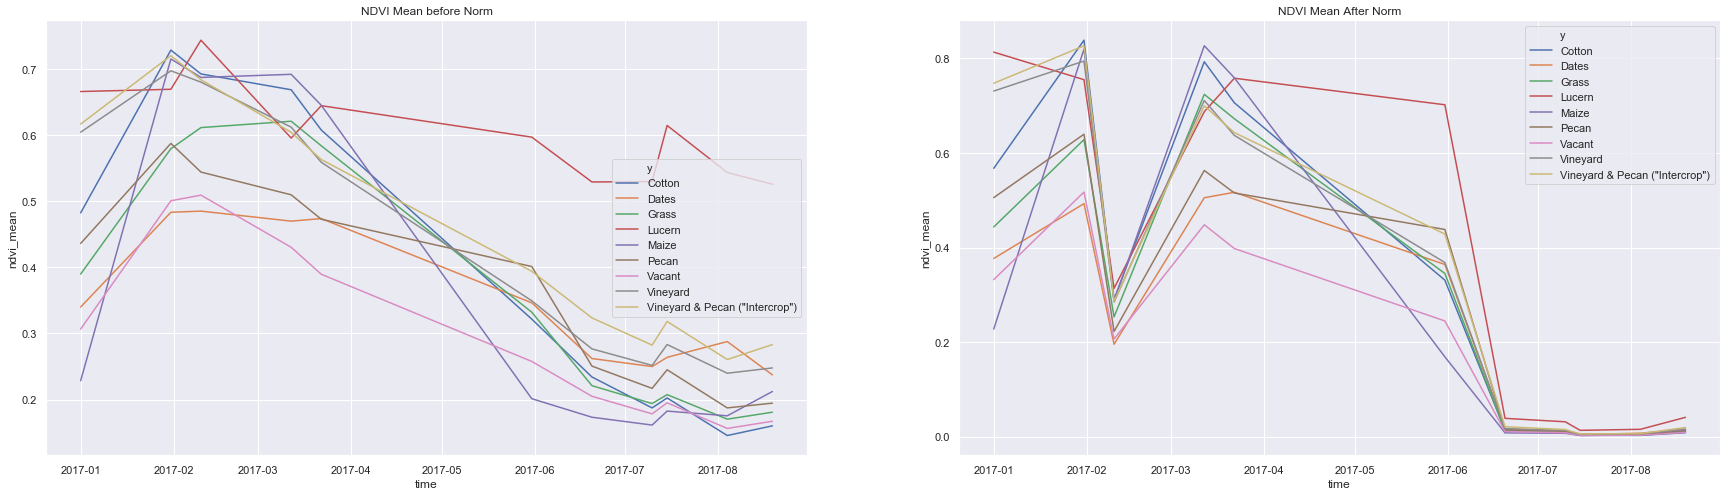

In [12]:
fig, axes = plt.subplots(1,2,figsize=(30,8))

ax = axes[0]
sns.lineplot(data=agg_df_1, x='time', y='ndvi_mean', hue='y', ax=ax)
ax.set_title('NDVI Mean before Norm')
ax.legend(loc='best')

ax = axes[1]
sns.lineplot(data=agg_df_2, x='time', y='ndvi_mean', hue='y', ax=ax)
ax.set_title('NDVI Mean After Norm')
ax.legend(loc='best')

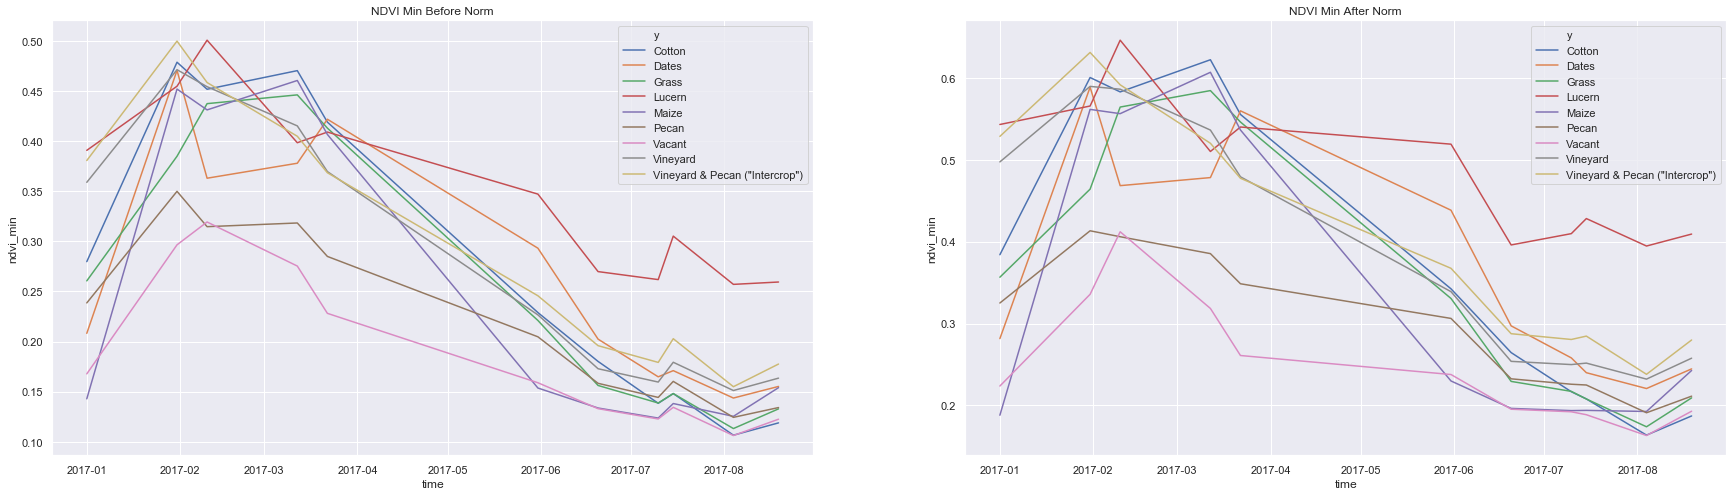

In [13]:
fig, axes = plt.subplots(1,2,figsize=(30,8))

ax = axes[0]
sns.lineplot(data=agg_df_1, x='time', y='ndvi_min', hue='y', ax=ax)
ax.set_title('NDVI Min Before Norm')
ax.legend(loc='best')

ax = axes[1]
sns.lineplot(data=agg_df_2, x='time', y='ndvi_min', hue='y', ax=ax)
ax.set_title('NDVI Min After Norm')
ax.legend(loc='best')

## Transform Dataset for MVTS Classification

In [14]:
def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, 11, n_features))
    
    classes = {}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes
    

In [15]:
train_data, train_labels_dict = transform_dataset(train_features_df)
test_data, _ = transform_dataset(test_features_df)

print('Train data:\t\t',train_data.shape)
print('Test data:\t\t',test_data.shape)

Train data:		 (2494, 11, 5)
Test data:		 (1074, 11, 5)


## Start Modelling Process

### Create validation set

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Copy for later
data = train_data.copy()

train_labels = list(train_labels_dict.values())
train_indexes = list(train_labels_dict.keys())
train_idx, val_idx, train_labels, val_labels = train_test_split(train_indexes, train_labels, stratify=train_labels)

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(train_labels).reshape(-1,1))
val_labels_enc = le.transform(np.array(val_labels).reshape(-1,1))

train_data = data[train_idx,:, :]
val_data = data[val_idx,:, :]

print('train data : ',train_data.shape)
print('val data : ',val_data.shape)

train data :  (1870, 11, 5)
val data :  (624, 11, 5)


### Create model

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

from src.visualization.tf_viz import PlotLosses

es = EarlyStopping(monitor='val_loss', verbose=1, patience=200)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)

plot_losses = PlotLosses()

def get_model(n_features):

    model = models.Sequential()
    model.add(layers.GRU(8, input_shape=(11, n_features)))
    model.add(layers.Flatten())
    model.add(layers.Dense(9, activation='softmax'))
    
    return model


model = get_model(train_data.shape[-1])
optimizer = keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=optimizer,
              loss=keras.metrics.sparse_categorical_crossentropy,
              metrics=[keras.metrics.sparse_categorical_crossentropy])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 8)                 360       
_________________________________________________________________
flatten (Flatten)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 9)                 81        
Total params: 441
Trainable params: 441
Non-trainable params: 0
_________________________________________________________________


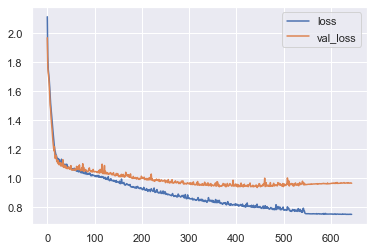


Epoch 00645: ReduceLROnPlateau reducing learning rate to 3.000000142492354e-05.
1870/1870 - 0s - loss: 0.7524 - sparse_categorical_crossentropy: 0.7524 - val_loss: 0.9668 - val_sparse_categorical_crossentropy: 0.9668
Epoch 00645: early stopping


In [18]:
model.fit(train_data, 
          train_labels_enc,
          batch_size=64,
          validation_data=(val_data, val_labels_enc), 
          verbose=2,
          epochs=2000,
          callbacks=[plot_losses, es, reduce_lr])

In [19]:
from sklearn.metrics import log_loss

val_preds = model.predict(val_data)
train_preds = model.predict(train_data)
print('val loss: ',log_loss(val_labels_enc, val_preds))
print('train loss: ',log_loss(train_labels_enc, train_preds))

val loss:  0.9668102593105943
train loss:  0.7514086970434409


## Make Submission

In [20]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict(test_data)
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

,crop_id_1,crop_id_2,crop_id_3,crop_id_4,crop_id_5,crop_id_6,crop_id_7,crop_id_8,crop_id_9
field_id,,,,,,,,,
5,0.027626,0.002895,0.007216,0.009105,0.005656,0.043714,0.008274,0.812434,0.083080
6,0.049306,0.003269,0.012817,0.013121,0.007712,0.045018,0.013508,0.774668,0.080580
10,0.002802,0.001468,0.001255,0.004510,0.001845,0.019862,0.003553,0.886059,0.078644
18,0.003441,0.001677,0.001423,0.004799,0.001623,0.018710,0.003859,0.885115,0.079353
23,0.004836,0.002495,0.002983,0.011777,0.002441,0.039555,0.008613,0.844557,0.082742


In [22]:
from config import subs_dir

sub_df.to_csv(subs_dir / 'gru_ndvi_extra_stats.csv')

In [ ]:
nans = lambda df: df[df.isnull().any(axis=1)]

nans(sub_df.fillna(sub_df.mean()))